# Error analysis

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib.colors import LogNorm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import xarray as xr
import rasterio as rio
import rioxarray
import pandas as pd

import deep_snow.models
import deep_snow.dataset
from deep_snow.utils import calc_norm, undo_norm, db_scale, calc_dowy
from deep_snow.dataset import norm_dict

## Make predictions

In [2]:
# path to test tiles
test_tile_dir = '/mnt/Backups/gbrench/repos/deep-snow/data/test_tiles'
test_path_list = glob(f'{test_tile_dir}/ASO_50M_SD*.nc')

In [3]:
# path to model
model_path = '../../../weights/quinn_ResDepth_v10_256epochs'

In [4]:
# open test data and calculate required variables
def prep_dataset(data_fn):
    ds = xr.open_dataset(data_fn)
    # radar data variables
    # convert to decibels
    ds['snowon_vv'] = (('y', 'x'), db_scale(ds['snowon_vv']))
    ds['snowon_vh'] =  (('y', 'x'),db_scale(ds['snowon_vh']))
    ds['snowoff_vv'] =  (('y', 'x'),db_scale(ds['snowoff_vv']))
    ds['snowoff_vh'] =  (('y', 'x'),db_scale(ds['snowoff_vh']))
    
    # calculate variables
    ds['snowon_cr'] = ds['snowon_vh'] - ds['snowon_vv']
    ds['snowoff_cr'] = ds['snowoff_vh'] - ds['snowoff_vv']
    ds['delta_cr'] = ds['snowon_cr'] - ds['snowoff_cr']

    ds['ndvi'] = (ds['B08'] - ds['B04'])/(ds['B08'] + ds['B04'])
    ds['ndsi'] = (ds['B03'] - ds['B11'])/(ds['B03'] + ds['B11'])
    ds['ndwi'] = (ds['B03'] - ds['B08'])/(ds['B03'] + ds['B08'])

    # dowy
    dowy_1d = calc_dowy(pd.to_datetime(data_fn.split('_')[5]).dayofyear)
    ds['dowy'] = (('y', 'x'), np.full_like(ds['latitude'], dowy_1d))

    return ds

In [5]:
# make predictions on the test data
def apply_model(ds, model, input_channels):
    ds = ds.fillna(0)

    data_dict = {}
    # normalize layers 
    data_dict['snowon_vv'] = calc_norm(torch.Tensor(ds['snowon_vv'].values), norm_dict['vv'])
    data_dict['delta_cr'] = calc_norm(torch.Tensor(ds['delta_cr'].values), norm_dict['delta_cr'])
    data_dict['green'] = calc_norm(torch.Tensor(ds['B03'].values), norm_dict['green'])
    data_dict['swir2'] = calc_norm(torch.Tensor(ds['B12'].values), norm_dict['swir2'])
    data_dict['ndsi'] = calc_norm(torch.Tensor(ds['ndsi'].values), [-1, 1])
    data_dict['ndwi'] = calc_norm(torch.Tensor(ds['ndwi'].values), [-1, 1])
    data_dict['elevation'] = calc_norm(torch.Tensor(ds['elevation'].values), norm_dict['elevation'])
    data_dict['latitude'] = calc_norm(torch.Tensor(ds['latitude'].values), norm_dict['latitude'])
    data_dict['longitude'] = calc_norm(torch.Tensor(ds['longitude'].values), norm_dict['longitude'])

    # clamp values, add dimensions
    data_dict = {key: torch.clamp(data_dict[key], 0, 1)[None, None, :, :] for key in data_dict.keys()}
    inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)

    # predict noise in tile
    with torch.no_grad():
        pred_sd = model(inputs.to('cuda'))
    pred_sd = pred_sd.detach().squeeze()
    
    # undo normalization
    pred_sd = undo_norm(pred_sd, deep_snow.dataset.norm_dict['aso_sd'])
    # add to xarray dataset
    ds['predicted_sd'] = (('y', 'x'), pred_sd.to('cpu').numpy())
    ds['predicted_sd'] = ds['predicted_sd'].where(ds['predicted_sd'] > 0, 0)
    
    return ds

In [6]:
 # define input channels for model
input_channels = [
    'snowon_vv',
    'delta_cr',
    'green',
    'swir2',
    'ndsi',
    'ndwi',
    'elevation',
    'latitude',
    'longitude']

# load model 
model = deep_snow.models.ResDepth(n_input_channels=len(input_channels), depth=5)
model.load_state_dict(torch.load(model_path))
model.to('cuda');

/tmp/ipykernel_8993/1686056867.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [7]:
# select variables to examine uncertainty with
accuracy_list = ['aso_sd',
                 'predicted_sd',
                 'fcf',
                 'elevation',
                 'slope',
                 'aspect',
                 'dowy',
                 'snow_class',
                 'mtn_range']

In [8]:
# make predictions for all test data and load into a pandas dataframe
df = None

for i, tile_path in enumerate(test_path_list):
    ds = prep_dataset(tile_path)
    ds = ds.isel(x=slice(0, 640), y=slice(0, 640))
    ds = apply_model(ds, model, input_channels)
    ds['all_gaps'] = ds['aso_gap_map'] + ds['rtc_gap_map'] + ds['s2_gap_map']
    ds = ds.where(ds.all_gaps == 0, drop=True)
    tile_df = ds[accuracy_list].to_dataframe().reset_index()
    tile_df = tile_df.dropna(subset=['aso_sd'])
    tile_df = tile_df.drop(columns=['y', 'x', 'band', 'spatial_ref'])
    if df is None:
        df = tile_df
    else:
        df = pd.concat([df, tile_df], ignore_index=True)

## Analyze overall error

In [102]:
# # subsample data for fast plotting
# df = df.sample(100000)

In [9]:
# calculate error and absolute value error
df['error'] = df.aso_sd - df.predicted_sd
df['abs_error'] = df.error.abs()

In [10]:
# remove values where snow depth is 0
aso_sd_clean = df.aso_sd.where(df.aso_sd > 0).dropna()
predicted_sd_clean = df.predicted_sd.where(df.aso_sd > 0).dropna()

# Calculate metrics
r2 = r2_score(aso_sd_clean, predicted_sd_clean)
mse = mean_squared_error(aso_sd_clean, predicted_sd_clean)
mae = mean_absolute_error(aso_sd_clean, predicted_sd_clean)
pearson_r, _ = pearsonr(aso_sd_clean, predicted_sd_clean)

print(f'R²: {r2}')
print(f'pearson r: {pearson_r}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

R²: 0.762718915939331
pearson r: 0.8892243250979581
MSE: 0.5462779998779297
MAE: 0.4817989766597748


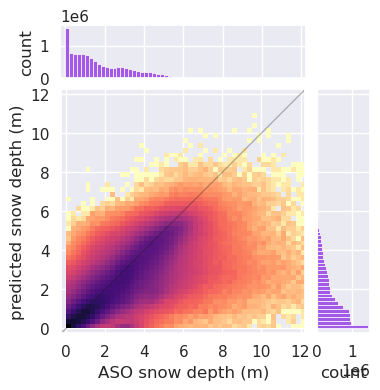

In [11]:
# plot predictions 
sns.set_theme()
axmin = -0.25
axmax = 12.25

# Create a grid layout
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(5, 5, hspace=0.2, wspace=0.2)
ax_main = fig.add_subplot(gs[1:5, 0:4])
ax_histx = fig.add_subplot(gs[0, 0:4])
ax_histy = fig.add_subplot(gs[1:5, 4])

# Main plot
sns.histplot(ax=ax_main, x=df.aso_sd[df.aso_sd > 0], y=df.predicted_sd[df.aso_sd > 0],
             cmap='magma_r', cbar=False, alpha=1, binwidth=0.25, vmin=None, vmax=None, norm=LogNorm())
ax_main.plot([-15, 30], [-15, 30], color='k', linestyle='-', linewidth=1, alpha=0.3)
ax_main.set_xlabel('ASO snow depth (m)')
ax_main.set_ylabel('predicted snow depth (m)')
ax_main.set_box_aspect(1)
ax_main.set_xlim(axmin, axmax)
ax_main.set_ylim(axmin, axmax)
ax_main.set_xticks([0, 2, 4, 6, 8, 10, 12])
ax_main.set_yticks([0, 2, 4, 6, 8, 10, 12])

ax_main.tick_params(axis='x', pad=2)
ax_main.tick_params(axis='y', pad=2)

# Histogram for x-axis (ASO snow depth)
sns.histplot(ax=ax_histx, x=df.aso_sd[df.aso_sd > 0], binwidth=0.2, color='blueviolet', edgecolor='white', linewidth=0.5)
ax_histx.set_ylabel('count')
ax_histx.set_xlabel('')
ax_histx.set_xticklabels([])
ax_histx.set_xlim(axmin, axmax)
ax_histx.set_xticks([0, 2, 4, 6, 8, 10, 12])
ax_histx.tick_params(axis='x', pad=2)
ax_histx.tick_params(axis='y', pad=2)

# Histogram for y-axis (predicted snow depth)
sns.histplot(ax=ax_histy, y=df.predicted_sd[df.aso_sd > 0], binwidth=0.2, color='blueviolet', edgecolor='white', linewidth=0.5)
ax_histy.set_xlabel('count')
ax_histy.set_ylabel('')
ax_histy.set_ylim(axmin, axmax)
ax_histy.set_yticks([0, 2, 4, 6, 8, 10, 12])
ax_histy.set_yticklabels([])

ax_histy.tick_params(axis='x', pad=2)
ax_histy.tick_params(axis='y', pad=2)

#fig.tight_layout()

#fig.savefig('../../../figs/quinn_ResDepthv10_256epochs_2dhist_wcbar.png', dpi=400, bbox_inches='tight')

In [11]:
# accuracy where snow depth is 0
sd_0_mse = mean_squared_error(df.aso_sd[df.aso_sd == 0], df.predicted_sd[df.aso_sd == 0])
sd_0_mae = mean_absolute_error(df.aso_sd[df.aso_sd == 0], df.predicted_sd[df.aso_sd == 0])

print(f'MSE: {sd_0_mse}')
print(f'MAE: {sd_0_mae}')

MSE: 0.021866081282496452
MAE: 0.047547243535518646


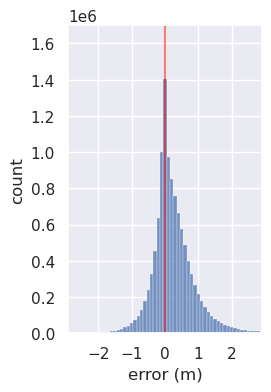

In [13]:
# plot distribution of errors
sns.set_theme()

f, ax = plt.subplots(figsize=(2.5, 4))
sns.histplot(df.error[df.aso_sd > 0], ax=ax, bins=np.arange(-3, 3, 0.1)-0.05)
ax.set_xlim(-2.9, 2.9)
ax.set_ylim(0, 1.7*1e6)
ax.set_xlabel('error (m)')
ax.set_ylabel('count')
ax.axvline(0, c='red', alpha=0.5)
ax.set_xticks([-2, -1, 0, 1, 2])

# f.savefig('../../../figs/quinn_ResDepthv10_256epochs_errorhist.png', dpi=400, bbox_inches='tight')

In [10]:
def nmad(a, c=1.4826):
    return np.median(np.fabs(a - np.median(a))) * c

In [13]:
print(f'median: {df.error[df.aso_sd > 0].median()}')
print(f'nmad: {nmad(df.error[df.aso_sd > 0])}')
print(f'skewness: {df.error[df.aso_sd > 0].skew()}')
print(f'kurtosis: {df.error[df.aso_sd > 0].kurtosis()}')

median: 0.1416642665863037
nmad: 0.44670961745381355
skewness: 1.884070873260498
kurtosis: 17.410249710083008


In [11]:
from scipy.interpolate import interp1d

In [12]:
# estimate bias with snow depth
bins = pd.qcut(df['aso_sd'], q=20, duplicates='drop')

# calculate central tendency of error (median) and cound for each bin
uncorrected_grouped = df.groupby(bins).agg({'error': ['median', 'count']}).reset_index()
uncorrected_grouped.columns = ['aso_sd_bin', 'bias_uncorrected', 'count']
# Calculate bin centers 
uncorrected_grouped['bin_center'] = uncorrected_grouped['aso_sd_bin'].apply(lambda x: x.mid)

uncorrected_interpolator = interp1d(uncorrected_grouped['bin_center'],
                        uncorrected_grouped['bias_uncorrected'],
                        kind='linear',
                        fill_value='extrapolate')
uncorrected_even_intervals = np.arange(df['aso_sd'].min(), df['aso_sd'].max(), 0.01)
if df['aso_sd'].max() not in uncorrected_even_intervals:
    uncorrected_even_intervals = np.append(uncorrected_even_intervals, df['aso_sd'].max())

uncorrected_interpolated_bias = uncorrected_interpolator(uncorrected_even_intervals)

/tmp/ipykernel_8993/2024919833.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  uncorrected_grouped = df.groupby(bins).agg({'error': ['median', 'count']}).reset_index()


(-0.1, 1.05)

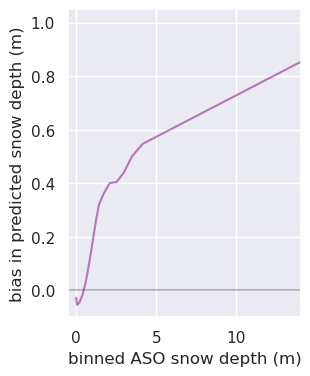

In [64]:
sns.set_theme()
# plot bias for each snow depth bin
f, ax = plt.subplots(figsize=(3, 4))
ax.axhline(0, c='gray', alpha=0.5)
scatter = ax.plot(uncorrected_even_intervals,
                  uncorrected_interpolated_bias,
                     #c=np.log(grouped['count'][grouped['count'] >= 1000]), 
                     c='purple', alpha=0.5, )
#f.colorbar(scatter, label='log(count)')
ax.set_xlabel('binned ASO snow depth (m)')
ax.set_ylabel('bias in predicted snow depth (m)')
ax.set_xlim(-0.5, 14)
ax.set_ylim(-0.1, 1.05)

#ax.set_aspect('equal')
#ax.set_aspect('equal')

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_sd_bias.png', dpi=400, bbox_inches='tight')

In [13]:
df['bias_uncorrected'] = np.interp(df['aso_sd'], uncorrected_even_intervals, uncorrected_interpolated_bias)
# Remove systematic error from error
df['error_debiased'] = df['error'] - df['bias_uncorrected']

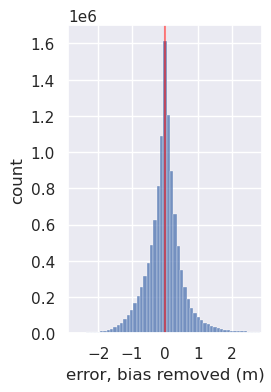

In [66]:
sns.set_theme()
# plot distribution of error with bias removed 
f, ax = plt.subplots(figsize=(2.5, 4))
sns.histplot(df.error_debiased[df.aso_sd > 0], ax=ax, bins=np.arange(-3, 3, 0.1)-0.05)
ax.set_xlim(-2.9, 2.9)
ax.set_ylim(0, 1.7*1e6)
ax.set_xlabel('error, bias removed (m)')
ax.set_ylabel('count')
ax.axvline(0, c='red', alpha=0.5)
ax.set_xticks([-2, -1, 0, 1, 2])

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_errorhist_bias_removed.png', dpi=400, bbox_inches='tight')

In [68]:
print(f'median: {df.error_debiased[df.aso_sd > 0].median()}')
print(f'nmad: {nmad(df.error_debiased[df.aso_sd > 0])}')
print(f'skewness: {df.error_debiased[df.aso_sd > 0].skew()}')
print(f'kurtosis: {df.error_debiased[df.aso_sd > 0].kurtosis()}')

median: 0.00030889090183379604
nmad: 0.3770238872748115
skewness: 1.5791295215719112
kurtosis: 20.434363285299074


## identify and correct systematic error

In [14]:
# estimate bias with snow depth
bins = pd.qcut(df['predicted_sd'], q=20, duplicates='drop')
# calculate central tendency of error (median) and cound for each bin
predicted_grouped = df.groupby(bins).agg({'error': ['median', 'count']}).reset_index()
predicted_grouped.columns = ['predicted_sd_bin', 'bias_predicted', 'count']
# Calculate bin centers 
predicted_grouped['bin_center'] = predicted_grouped['predicted_sd_bin'].apply(lambda x: x.mid)

predicted_interpolator = interp1d(predicted_grouped['bin_center'],
                        predicted_grouped['bias_predicted'],
                        kind='linear',
                        fill_value='extrapolate')
predicted_even_intervals = np.arange(df['predicted_sd'].min(), df['predicted_sd'].max(), 0.01)
if df['predicted_sd'].max() not in predicted_even_intervals:
    predicted_even_intervals = np.append(predicted_even_intervals, df['predicted_sd'].max())

predicted_interpolated_bias = predicted_interpolator(predicted_even_intervals)

/tmp/ipykernel_8993/122725999.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_grouped = df.groupby(bins).agg({'error': ['median', 'count']}).reset_index()


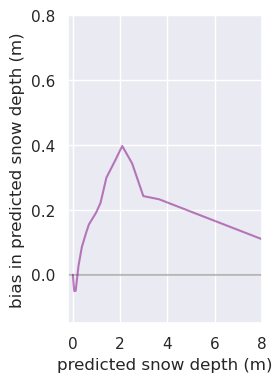

In [67]:
# plot bias for each snow depth bin
f, ax = plt.subplots(figsize=(2.5, 4))
ax.axhline(0, c='gray', alpha=0.5)
scatter = ax.plot(predicted_even_intervals,
                  predicted_interpolated_bias,
                     #c=np.log(grouped['count'][grouped['count'] >= 1000]), 
                     c='purple', alpha=0.5, )
#f.colorbar(scatter, label='log(count)')
ax.set_xlabel('predicted snow depth (m)')
ax.set_ylabel('bias in predicted snow depth (m)')
ax.set_xlim(-0.2, 8)
ax.set_ylim(-0.15, 0.8)
ax.set_xticks([0, 2, 4, 6, 8])

#ax.set_aspect('equal')
#ax.set_aspect('equal')

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_sd_predicted_bias.png', dpi=400, bbox_inches='tight')

In [15]:
df['bias_predicted'] = np.interp(df['predicted_sd'], predicted_even_intervals, predicted_interpolated_bias)

# remove systematic error from error
df['predicted_sd_corrected'] = df['predicted_sd'] + df['bias_predicted']
df['error_corrected'] = df['aso_sd'] - df['predicted_sd_corrected']

In [26]:
# remove values where snow depth is 0
aso_sd_clean = df.aso_sd.where(df.aso_sd > 0).dropna()
predicted_sd_clean = df.predicted_sd_corrected.where(df.aso_sd > 0).dropna()

# Calculate metrics
r2 = r2_score(aso_sd_clean, predicted_sd_clean)
mse = mean_squared_error(aso_sd_clean, predicted_sd_clean)
mae = mean_absolute_error(aso_sd_clean, predicted_sd_clean)
pearson_r, _ = pearsonr(aso_sd_clean, predicted_sd_clean)

print(f'R²: {r2}')
print(f'pearson r: {pearson_r}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

R²: 0.7937001312797007
pearson r: 0.8921862455733152
MSE: 0.474951451895925
MAE: 0.4497353368017744


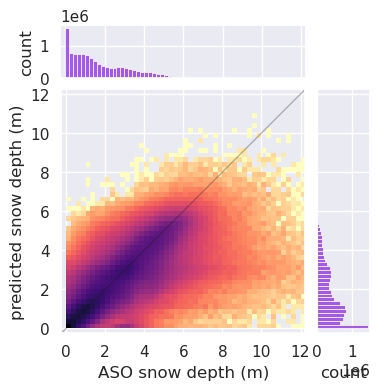

In [60]:
# plot predictions 
sns.set_theme()
axmin = -0.25
axmax = 12.25

# Create a grid layout
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(5, 5, hspace=0.2, wspace=0.2)
ax_main = fig.add_subplot(gs[1:5, 0:4])
ax_histx = fig.add_subplot(gs[0, 0:4])
ax_histy = fig.add_subplot(gs[1:5, 4])

# Main plot
sns.histplot(ax=ax_main, x=df.aso_sd[df.aso_sd > 0], y=df.predicted_sd_corrected[df.aso_sd > 0],
             cmap='magma_r', cbar=False, alpha=1, binwidth=0.25, vmin=None, vmax=None, norm=LogNorm())
ax_main.plot([-15, 30], [-15, 30], color='k', linestyle='-', linewidth=1, alpha=0.3)
ax_main.set_xlabel('ASO snow depth (m)')
ax_main.set_ylabel('predicted snow depth (m)')
ax_main.set_box_aspect(1)
ax_main.set_xlim(axmin, axmax)
ax_main.set_ylim(axmin, axmax)
ax_main.set_xticks([0, 2, 4, 6, 8, 10, 12])
ax_main.set_yticks([0, 2, 4, 6, 8, 10, 12])

ax_main.tick_params(axis='x', pad=2)
ax_main.tick_params(axis='y', pad=2)

# Histogram for x-axis (ASO snow depth)
sns.histplot(ax=ax_histx, x=df.aso_sd[df.aso_sd > 0], binwidth=0.2, color='blueviolet', edgecolor='white', linewidth=0.5)
ax_histx.set_ylabel('count')
ax_histx.set_xlabel('')
ax_histx.set_xticklabels([])
ax_histx.set_xlim(axmin, axmax)
ax_histx.set_xticks([0, 2, 4, 6, 8, 10, 12])
ax_histx.tick_params(axis='x', pad=2)
ax_histx.tick_params(axis='y', pad=2)

# Histogram for y-axis (predicted snow depth)
sns.histplot(ax=ax_histy, y=df.predicted_sd_corrected[df.aso_sd > 0], binwidth=0.2, color='blueviolet', edgecolor='white', linewidth=0.5)
ax_histy.set_xlabel('count')
ax_histy.set_ylabel('')
ax_histy.set_ylim(axmin, axmax)
ax_histy.set_yticks([0, 2, 4, 6, 8, 10, 12])
ax_histy.set_yticklabels([])

ax_histy.tick_params(axis='x', pad=2)
ax_histy.tick_params(axis='y', pad=2)

#fig.tight_layout()

fig.savefig('../../../figs/quinn_ResDepthv10_256epochs_2dhist_corrected.png', dpi=400, bbox_inches='tight')

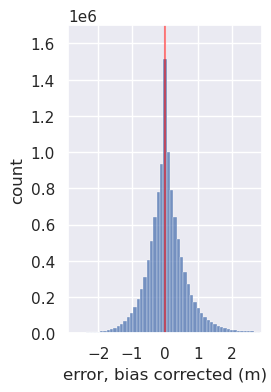

In [28]:
# plot distribution of error with bias removed 
f, ax = plt.subplots(figsize=(2.5, 4))
sns.histplot(df.error_corrected[df.aso_sd > 0], ax=ax, bins=np.arange(-3, 3, 0.1)-0.05)
ax.set_xlim(-2.9, 2.9)
ax.set_ylim(0, 1.7*1e6)
ax.set_xlabel('error, bias corrected (m)')
ax.set_ylabel('count')
ax.axvline(0, c='red', alpha=0.5)
ax.set_xticks([-2, -1, 0, 1, 2])

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_errorhist_bias_removed.png', dpi=400, bbox_inches='tight')

In [29]:
print(f'median: {df.error_corrected[df.aso_sd > 0].median()}')
print(f'nmad: {nmad(df.error_corrected[df.aso_sd > 0])}')
print(f'skewness: {df.error_corrected[df.aso_sd > 0].skew()}')
print(f'kurtosis: {df.error_corrected[df.aso_sd > 0].kurtosis()}')

median: 0.013604950251863375
nmad: 0.4434665066292397
skewness: 1.6535278828968238
kurtosis: 17.64805443323207


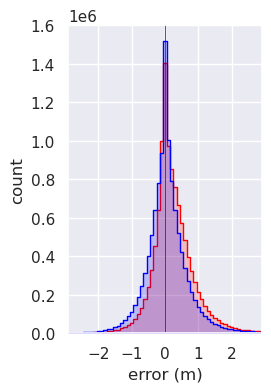

In [71]:
# plot error distributions for fig
f, ax = plt.subplots(figsize=(2.5, 4))
sns.histplot(df.error[df.aso_sd > 0], ax=ax, bins=np.arange(-3, 3, 0.1)-0.05, alpha=0.2, color='Red', element="step")
sns.histplot(df.error_corrected[df.aso_sd > 0], ax=ax, bins=np.arange(-3, 3, 0.1)-0.05, alpha=0.2, color='Blue', element="step")
ax.set_xlim(-2.9, 2.9)
ax.set_ylim(0, 1.6*1e6)
ax.set_xlabel('error (m)')
ax.set_ylabel('count')
ax.axvline(0, c='k', alpha=1, linewidth=0.5)
ax.set_xticks([-2, -1, 0, 1, 2])

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_errorhist.png', dpi=400, bbox_inches='tight')

## measure remaining systematic error

In [20]:
# estimate bias with snow depth
bin_width=0.5
bins = pd.qcut(df['aso_sd'], q=20, duplicates='drop')
# calculate central tendency of error (median) and cound for each bin
corrected_grouped = df.groupby(bins).agg({'error_corrected': ['median', 'count']}).reset_index()
corrected_grouped.columns = ['aso_sd_bin', 'bias_remaining', 'count']
# Calculate bin centers 
corrected_grouped['bin_center'] = corrected_grouped['aso_sd_bin'].apply(lambda x: x.mid)

corrected_interpolator = interp1d(corrected_grouped['bin_center'],
                        corrected_grouped['bias_remaining'],
                        kind='linear',
                        fill_value='extrapolate')
corrected_even_intervals = np.arange(df['aso_sd'].min(), df['aso_sd'].max(), 0.01)
if df['aso_sd'].max() not in corrected_even_intervals:
    corrected_even_intervals = np.append(corrected_even_intervals, df['aso_sd'].max())

corrected_interpolated_bias = corrected_interpolator(corrected_even_intervals)

/tmp/ipykernel_8993/4221512936.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corrected_grouped = df.groupby(bins).agg({'error_corrected': ['median', 'count']}).reset_index()


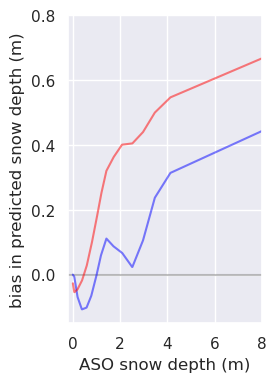

In [70]:
# plot bias for each snow depth bin
f, ax = plt.subplots(figsize=(2.5, 4))
ax.axhline(0, c='gray', alpha=0.5)
ax.plot(corrected_even_intervals,
        corrected_interpolated_bias,
        c='blue', alpha=0.5)
ax.plot(uncorrected_even_intervals,
        uncorrected_interpolated_bias,
        c='red', alpha=0.5)
#f.colorbar(scatter, label='log(count)')
ax.set_xlabel('ASO snow depth (m)')
ax.set_ylabel('bias in predicted snow depth (m)')
ax.set_xlim(-0.2, 8)
ax.set_ylim(-0.15, 0.8)
ax.set_xticks([0, 2, 4, 6, 8])

#ax.set_aspect('equal')
#ax.set_aspect('equal')

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_sd_bias.png', dpi=400, bbox_inches='tight')

In [21]:
df['bias_remaining'] = np.interp(df['aso_sd'], corrected_even_intervals, corrected_interpolated_bias)

# Random error

In [22]:
# remove pixels with snow depths of 0
df = df[df['aso_sd'] > 0]

## snow depth

/tmp/ipykernel_8993/374327006.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_sd_corrected_bins'] = pd.qcut(df['predicted_sd_corrected'], q=10, duplicates='drop')
/tmp/ipykernel_8993/374327006.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin_center'] = df['predicted_sd_corrected_bins'].apply(lambda x: (x.left + x.right) / 2)
/tmp/ipykernel_8993/374327006.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pa

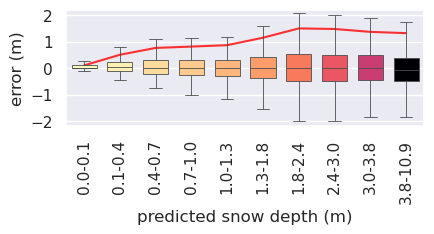

In [23]:
sns.set_theme()
from matplotlib.cm import ScalarMappable

# predicted snow depth
df['predicted_sd_corrected_bins'] = pd.qcut(df['predicted_sd_corrected'], q=10, duplicates='drop')
df['bin_center'] = df['predicted_sd_corrected_bins'].apply(lambda x: (x.left + x.right) / 2)

nmad_values = df.groupby('predicted_sd_corrected_bins')['error_corrected'].agg(nmad).reset_index()
nmad_values['bin_center'] = nmad_values['predicted_sd_corrected_bins'].apply(lambda x: (x.left + x.right) / 2)

f, ax = plt.subplots(1, 1, figsize=(4.5, 2.5))
sns.lineplot(nmad_values['error_corrected']*2, ax=ax, c='red', alpha=0.8)
boxplot = sns.boxplot(x=df.predicted_sd_corrected_bins,
            y=df.error_corrected,
            ax=ax, showfliers=False,
           linewidth=0.6, width=0.7, patch_artist=True)

# Calculate the center values of each bin
center_values = [(interval.left + interval.right) / 2 for interval in df.predicted_sd_corrected_bins.cat.categories]

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(min(center_values), max(center_values))
colors = plt.cm.magma_r(norm(center_values))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax.tick_params(axis='x', rotation=90)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.predicted_sd_corrected_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_ylabel('error (m)')
ax.set_xlabel('predicted snow depth (m)')
ax.set_ylim(-2.2, 2.2)

# # Add colorbar
# sm = ScalarMappable(cmap='magma_r', norm=norm)
# sm.set_array([])
# cbar = f.colorbar(sm, ax=ax)
# cbar.set_label('snow depth (m)', rotation=270, labelpad=15)

plt.tight_layout()

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_predicted_sd_randomerror.png', dpi=400, bbox_inches='tight')

## slope

/tmp/ipykernel_8993/374018070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['slope_bins'] = pd.qcut(df['slope'], q=10, duplicates='drop')
/tmp/ipykernel_8993/374018070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin_center'] = df['slope_bins'].apply(lambda x: (x.left + x.right) / 2)
/tmp/ipykernel_8993/374018070.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

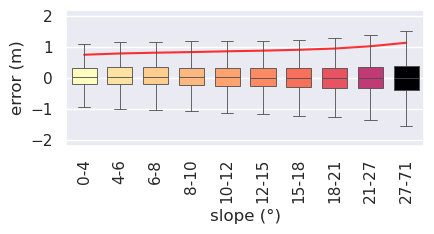

In [24]:
# slope
df['slope_bins'] = pd.qcut(df['slope'], q=10, duplicates='drop')
df['bin_center'] = df['slope_bins'].apply(lambda x: (x.left + x.right) / 2)

nmad_values = df.groupby('slope_bins')['error_corrected'].agg(nmad).reset_index()
nmad_values['bin_center'] = nmad_values['slope_bins'].apply(lambda x: (x.left + x.right) / 2)

f, ax = plt.subplots(1, 1, figsize=(4.5, 2.5))
sns.lineplot(nmad_values['error_corrected']*2, ax=ax, c='red', alpha=0.8)
boxplot = sns.boxplot(x=df.slope_bins,
            y=df.error_corrected,
            ax=ax, showfliers=False,
           linewidth=0.6, width=0.7, patch_artist=True)

# Calculate the center values of each bin
center_values = [(interval.left + interval.right) / 2 for interval in df.slope_bins.cat.categories]

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(min(center_values), max(center_values))
colors = plt.cm.magma_r(norm(center_values))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax.tick_params(axis='x', rotation=90)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.0f}-{interval.right:.0f}" for interval in df.slope_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_ylabel('error (m)')
ax.set_xlabel('slope (\N{DEGREE SIGN})')
ax.set_ylim(-2.2, 2.2)

# # Add colorbar
# sm = ScalarMappable(cmap='magma_r', norm=norm)
# sm.set_array([])
# cbar = f.colorbar(sm, ax=ax)
# cbar.set_label('slope (\N{DEGREE SIGN})', rotation=270, labelpad=15)

plt.tight_layout()
#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_slope_randomerror.png', dpi=400, bbox_inches='tight')

## FCF

/tmp/ipykernel_8993/966289025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fcf_bins'] = pd.cut(df['fcf'], bins=10, duplicates='drop')
/tmp/ipykernel_8993/966289025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin_center'] = df['fcf_bins'].apply(lambda x: (x.left + x.right) / 2)
/tmp/ipykernel_8993/966289025.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

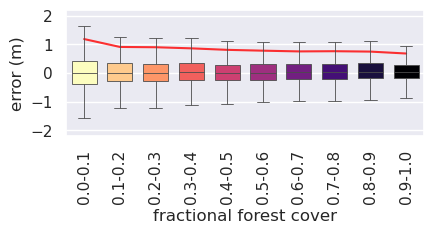

In [25]:
# fcf
df['fcf_bins'] = pd.cut(df['fcf'], bins=10, duplicates='drop')
df['bin_center'] = df['fcf_bins'].apply(lambda x: (x.left + x.right) / 2)

nmad_values = df.groupby('fcf_bins')['error_corrected'].agg(nmad).reset_index()
nmad_values['bin_center'] = nmad_values['fcf_bins'].apply(lambda x: (x.left + x.right) / 2)

f, ax = plt.subplots(1, 1, figsize=(4.5, 2.5))
sns.lineplot(nmad_values['error_corrected']*2, ax=ax, c='red', alpha=0.8)
boxplot = sns.boxplot(x=df.fcf_bins,
            y=df.error_corrected,
            ax=ax, showfliers=False,
           linewidth=0.6, width=0.7, patch_artist=True)

# Calculate the center values of each bin
center_values = [(interval.left + interval.right) / 2 for interval in df.fcf_bins.cat.categories]

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(min(center_values), max(center_values))
colors = plt.cm.magma_r(norm(center_values))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax.tick_params(axis='x', rotation=90)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.fcf_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_ylabel('error (m)')
ax.set_xlabel('fractional forest cover')

# # Add colorbar
# sm = ScalarMappable(cmap='magma_r', norm=norm)
# sm.set_array([])
# cbar = f.colorbar(sm, ax=ax)
# cbar.set_label('fractional\nforest cover', rotation=270, labelpad=25)
ax.set_ylim(-2.2, 2.2)

plt.tight_layout()

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_fcf_randomerror.png', dpi=400, bbox_inches='tight')

## Aspect

/tmp/ipykernel_8993/2779734613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aspect_bins'] = pd.cut(df['aspect'], bins=10, duplicates='drop')
/tmp/ipykernel_8993/2779734613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin_center'] = df['aspect_bins'].apply(lambda x: (x.left + x.right) / 2)
/tmp/ipykernel_8993/2779734613.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavio

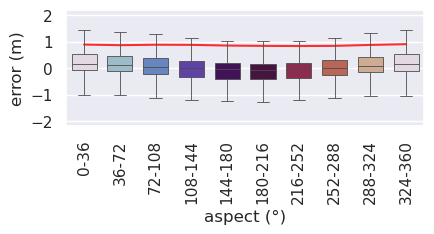

In [26]:
# aspect
df['aspect_bins'] = pd.cut(df['aspect'], bins=10, duplicates='drop')
df['bin_center'] = df['aspect_bins'].apply(lambda x: (x.left + x.right) / 2)

nmad_values = df.groupby('aspect_bins')['error_corrected'].agg(nmad).reset_index()
nmad_values['bin_center'] = nmad_values['aspect_bins'].apply(lambda x: (x.left + x.right) / 2)

f, ax = plt.subplots(1, 1, figsize=(4.5, 2.5))
sns.lineplot(nmad_values['error_corrected']*2, ax=ax, c='red', alpha=0.8)
boxplot = sns.boxplot(x=df.aspect_bins,
            y=df.error_corrected,
            ax=ax, showfliers=False,
           linewidth=0.6, width=0.7, patch_artist=True)

# Calculate the center values of each bin
center_values = [(interval.left + interval.right) / 2 for interval in df.aspect_bins.cat.categories]

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(min(center_values), max(center_values))
colors = plt.cm.twilight(norm(center_values))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax.tick_params(axis='x', rotation=90)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.0f}-{interval.right:.0f}" for interval in df.aspect_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_ylabel('error (m)')
ax.set_xlabel('aspect (\N{DEGREE SIGN})')

# # Add colorbar
# sm = ScalarMappable(cmap='twilight', norm=norm)
# sm.set_array([])
# cbar = f.colorbar(sm, ax=ax)
# cbar.set_label('aspect (\N{DEGREE SIGN})', rotation=270, labelpad=15)
ax.set_ylim(-2.2, 2.2)

plt.tight_layout()

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_aspect_randomerror.png', dpi=400, bbox_inches='tight')

## elevation

/tmp/ipykernel_8993/1194160251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elevation_bins'] = pd.qcut(df['elevation'], q=10, duplicates='drop')
/tmp/ipykernel_8993/1194160251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin_center'] = df['elevation_bins'].apply(lambda x: (x.left + x.right) / 2)
/tmp/ipykernel_8993/1194160251.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current 

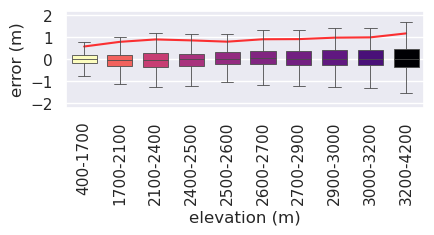

In [32]:
# elevation
df['elevation_bins'] = pd.qcut(df['elevation'], q=10, duplicates='drop')
df['bin_center'] = df['elevation_bins'].apply(lambda x: (x.left + x.right) / 2)

nmad_values = df.groupby('elevation_bins')['error_corrected'].agg(nmad).reset_index()
nmad_values['bin_center'] = nmad_values['elevation_bins'].apply(lambda x: (x.left + x.right) / 2)

f, ax = plt.subplots(1, 1, figsize=(4.5, 2.5))
sns.lineplot(nmad_values['error_corrected']*2, ax=ax, c='red', alpha=0.8)
boxplot = sns.boxplot(x=df.elevation_bins,
            y=df.error_corrected,
            ax=ax, showfliers=False,
           linewidth=0.6, width=0.7, patch_artist=True)

# Calculate the center values of each bin
center_values = [(interval.left + interval.right) / 2 for interval in df.elevation_bins.cat.categories]

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(min(center_values), max(center_values))
colors = plt.cm.magma_r(norm(center_values))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax.tick_params(axis='x', rotation=90)

# Customize x-axis tick labels
new_labels = [f"{round(abs(interval.left)/100)*100}-{round(interval.right/100)*100}" for interval in df.elevation_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_ylabel('error (m)')
ax.set_xlabel('elevation (m)')
ax.set_ylim(-2.2, 2.2)

# # Add colorbar
# sm = ScalarMappable(cmap='magma_r', norm=norm)
# sm.set_array([])
# cbar = f.colorbar(sm, ax=ax)
# cbar.set_label('elevation (m)', rotation=270, labelpad=15)

plt.tight_layout()

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_elevation_randomerror.png', dpi=400, bbox_inches='tight')

## month

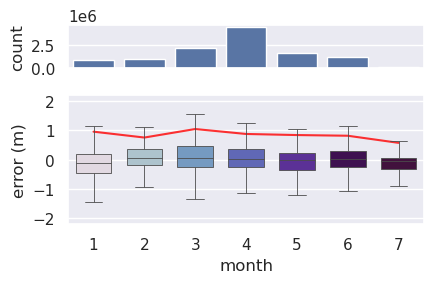

In [71]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df['month'] = df.time.dt.month
month_counts = df['month'].value_counts()
valid_months = month_counts[month_counts >= 1000].index
filtered_df = df[df['month'].isin(valid_months)]

nmad_values = filtered_df.groupby('month')['error_corrected'].agg(nmad).reset_index()

f, ax = plt.subplots(2, 1, figsize=(4.5, 3), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
sns.barplot(filtered_df.groupby('month').count().aso_sd, ax=ax[0])
ax[0].set_xlim(0, 7)
ax[0].set_ylabel('count')
# ax[0].set_yscale('log')

# ax[0].set_yticks([10**3, 10**6])
# ax[0].get_yaxis().set_major_formatter(ScalarFormatter())

sns.lineplot(nmad_values['error_corrected']*2, ax=ax[1], c='red', alpha=0.8)
boxplot = sns.boxplot(x=filtered_df.month,
                      y=filtered_df.error_corrected,
                      ax=ax[1], showfliers=False,
                      linewidth=0.6, width=0.7, patch_artist=True)

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(1, 12)
colors = plt.cm.twilight(norm(nmad_values.month))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax[1].tick_params(axis='x')

ax[1].set_yticks([-2, -1, 0, 1, 2])
ax[1].set_ylabel('error (m)')
ax[1].set_xlabel('month')
ax[1].set_ylim(-2.2, 2.2)

# # Add colorbar outside the plot area
# sm = ScalarMappable(cmap='twilight', norm=norm)
# sm.set_array([])
# cbar_ax = inset_axes(ax[1], width="2%", height="100%", loc='center left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax[1].transAxes, borderpad=0)
# cbar = f.colorbar(sm, cax=cbar_ax)
# cbar.set_label('month', rotation=270, labelpad=15)

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.02)

plt.tight_layout()

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_month_randomerror.png', dpi=400, bbox_inches='tight')

## mountain range

In [19]:
import geopandas as gpd

In [20]:
mtn_gdf = gpd.read_file('../../../data/polygons/GMBA_Inventory_v2.0_standard_300.shp')

In [21]:
df['mtn_range'] = df['mtn_range'].round()

In [22]:
# Perform the merge
df = df.merge(mtn_gdf[['GMBA_V2_ID', 'MapName']], left_on='mtn_range', right_on='GMBA_V2_ID', how='left')

# Drop the GMBA_V2_ID column if you don't need it
df.drop(columns=['GMBA_V2_ID'], inplace=True)

In [74]:
# Count the number of rows for each MapName
mapname_counts = df['MapName'].value_counts()

# Filter out MapNames with fewer than 1000 rows
valid_mapnames = mapname_counts[mapname_counts >= 1000].index

# Keep only the rows with valid MapNames
filtered_df = df[df['MapName'].isin(valid_mapnames)]

/tmp/ipykernel_27023/2934588134.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([label.get_text().replace(' ', '\n') for label in xticklabels])


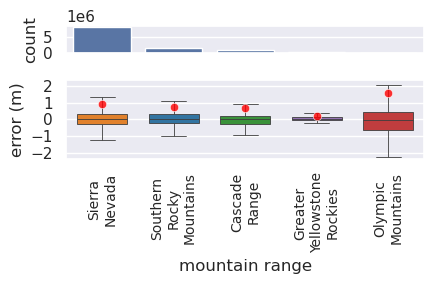

In [75]:
sns.set_theme()
nmad_values = filtered_df.groupby('MapName')['error_corrected'].agg(nmad).reset_index()
order = filtered_df['MapName'].value_counts().index
nmad_values = nmad_values.set_index('MapName').loc[order].reset_index()

f, ax = plt.subplots(2, 1, figsize=(4.5, 3), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
sns.barplot(filtered_df.groupby('MapName').count().aso_sd, ax=ax[0], order=order)
ax[0].set_xlim(0, 7)
ax[0].set_ylabel('count')
# ax[0].set_yscale('log')

# ax[0].set_yticks([10**3, 10**6])
# ax[0].get_yaxis().set_major_formatter(ScalarFormatter())

sns.scatterplot(nmad_values['error_corrected']*2, ax=ax[1], c='red', alpha=0.8, zorder=2)
boxplot = sns.boxplot(x=filtered_df.MapName,
            y=filtered_df.error_corrected,
                      hue=filtered_df.MapName, palette = 'tab10',
            ax=ax[1], showfliers=False,
           linewidth=0.6, width=0.7, order=order, zorder=1)

xticklabels = ax[1].get_xticklabels()
ax[1].set_xticklabels([label.get_text().replace(' ', '\n') for label in xticklabels])

ax[1].tick_params(axis='x', rotation=90, labelsize=10)
ax[1].set_ylim(-2.4, 2.4)

ax[1].set_yticks([-2, -1, 0, 1, 2])
ax[1].set_ylabel('error (m)')
ax[1].set_xlabel('mountain range')

plt.tight_layout()

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_mountainrange_randomerror.png', dpi=400, bbox_inches='tight')

## snow class

In [40]:
snow_class_dic = {'Tundra':1,
                  'Boreal Forest':2,
                  'Maritime':3,
                  'Ephemeral':4,
                  'Prairie':5,
                  'Montane Forest':6,
                  'Ice':7,
                  'Ocean':8,
                  'Fill':9}

reverse_snow_class_dic = {v: k for k, v in snow_class_dic.items()}

# Add the snow_class_label column to your dataframe
df['snow_class_label'] = df['snow_class'].map(reverse_snow_class_dic)

In [68]:
# Count the number of rows for each MapName
snow_class_counts = df['snow_class_label'].value_counts()

# Filter out MapNames with fewer than 1000 rows
valid_snow_classes = snow_class_counts[snow_class_counts >= 1000].index

# Keep only the rows with valid MapNames
filtered_df = df[df['snow_class_label'].isin(valid_snow_classes)]

/tmp/ipykernel_27023/1581582516.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([label.get_text().replace(' ', '\n') for label in xticklabels])


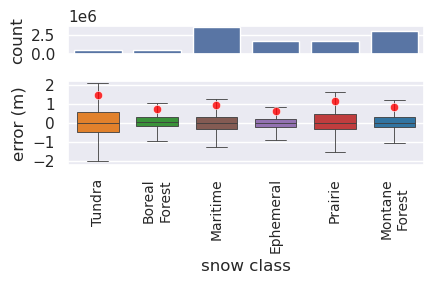

In [70]:
from matplotlib.ticker import ScalarFormatter

order = [label for label in list(snow_class_dic.keys()) if label in filtered_df.snow_class_label.values]

nmad_values = filtered_df.groupby('snow_class_label')['error_corrected'].agg(nmad).reset_index()
nmad_values = nmad_values.set_index('snow_class_label').loc[order].reset_index()

f, ax = plt.subplots(2, 1, figsize=(4.5, 3), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
sns.barplot(filtered_df.groupby('snow_class_label').count().aso_sd, order=order, ax=ax[0])
ax[0].set_xlim(0, 7)
ax[0].set_ylabel('count')
# ax[0].set_yscale('log')

# ax[0].set_yticks([10**3, 10**6])
# ax[0].get_yaxis().set_major_formatter(ScalarFormatter())

boxplot = sns.boxplot(x=filtered_df.snow_class_label,
                      y=filtered_df.error_corrected,
                      hue=filtered_df.snow_class_label, order=order, palette = 'tab10',
                      ax=ax[1], showfliers=False, linewidth=0.6, width=0.7, legend=False, zorder=1)
sns.scatterplot(nmad_values['error_corrected']*2, ax=ax[1], c='red', alpha=0.8, zorder=2)

xticklabels = ax[1].get_xticklabels()
ax[1].set_xticklabels([label.get_text().replace(' ', '\n') for label in xticklabels])

ax[1].tick_params(axis='x', rotation=90, labelsize=10)

ax[1].set_yticks([-2, -1, 0, 1, 2])
ax[1].set_ylabel('error (m)')
ax[1].set_xlabel('snow class')
ax[1].set_ylim(-2.2, 2.2)

plt.tight_layout()

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_snowclass_randomerror.png', dpi=400, bbox_inches='tight')

## heatmaps--random error distribution over two variables

In [101]:
grouped_df = df.groupby(['predicted_sd_corrected_bins', 'elevation_bins']).agg({'error_corrected': [nmad, 'count']}).reset_index()
grouped_df.columns = ['predicted_sd_corrected', 'elevation', 'nmad', 'count']
grouped_df = grouped_df[grouped_df['count'] >= 1000]
heatmap_data = grouped_df.pivot(index='predicted_sd_corrected', columns='elevation', values='nmad')

/tmp/ipykernel_8993/312321145.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['predicted_sd_corrected_bins', 'elevation_bins']).agg({'error_corrected': [nmad, 'count']}).reset_index()


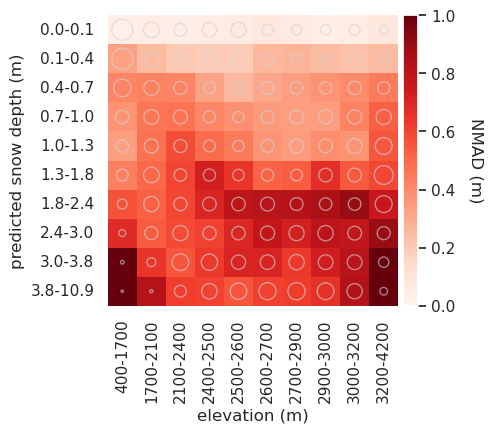

In [102]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the plot
f, ax = plt.subplots(figsize=(4, 4))
heatmap = sns.heatmap(heatmap_data, vmin=0, vmax=1, cmap='Reds', ax=ax, cbar=False)

# Customize x-axis tick labels
new_labels = [f"{round(abs(interval.left)/100)*100}-{round(interval.right/100)*100}" for interval in df.elevation_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_xlabel('elevation (m)')

# Customize y-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.predicted_sd_corrected_bins.cat.categories]
ax.set_yticklabels(new_labels)
ax.set_ylabel('predicted snow depth (m)')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar with adjusted size
cbar = plt.colorbar(heatmap.get_children()[0], cax=cax)
cbar.set_label('NMAD (m)', rotation=270, labelpad=20)

# Plot scatter points on top of heatmap
for i in range(len(grouped_df)):
    x = grouped_df['elevation'].cat.codes[i]
    y = grouped_df['predicted_sd_corrected'].cat.codes[i]
    size = grouped_df['count'][i] / 1200  # Scale the size for better visualization
    ax.scatter(x + 0.5, y + 0.5, s=size, c='none', edgecolor='lightgray', alpha=0.6)

ax.set_aspect('equal')

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_pred_sd_elevation_heatmap.png', dpi=400, bbox_inches='tight')

In [103]:
grouped_df = df.groupby(['predicted_sd_corrected_bins', 'slope_bins']).agg({'error_corrected': [nmad, 'count']}).reset_index()
grouped_df.columns = ['predicted_sd_corrected', 'slope', 'nmad', 'count']
grouped_df = grouped_df[grouped_df['count'] >= 1000]
heatmap_data = grouped_df.pivot(index='predicted_sd_corrected', columns='slope', values='nmad')

/tmp/ipykernel_8993/1336199744.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['predicted_sd_corrected_bins', 'slope_bins']).agg({'error_corrected': [nmad, 'count']}).reset_index()


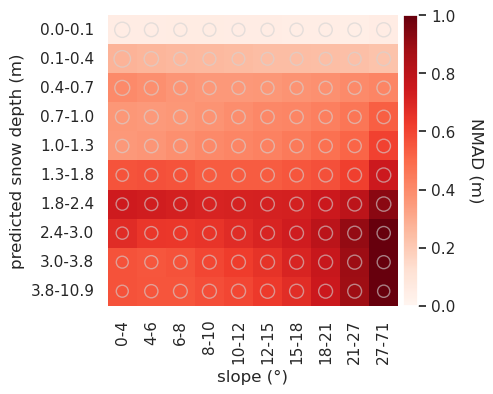

In [104]:
# Create the plot
f, ax = plt.subplots(figsize=(4, 4))
heatmap = sns.heatmap(heatmap_data, vmin=0, vmax=1, cmap='Reds', ax=ax, cbar=False)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.0f}-{interval.right:.0f}" for interval in df.slope_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_xlabel('slope (\N{DEGREE SIGN})')

# Customize y-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.predicted_sd_corrected_bins.cat.categories]
ax.set_yticklabels(new_labels)
ax.set_ylabel('predicted snow depth (m)')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar with adjusted size
cbar = plt.colorbar(heatmap.get_children()[0], cax=cax)
cbar.set_label('NMAD (m)', rotation=270, labelpad=20)

# Plot scatter points on top of heatmap
for i in range(len(grouped_df)):
    x = grouped_df['slope'].cat.codes[i]
    y = grouped_df['predicted_sd_corrected'].cat.codes[i]
    size = grouped_df['count'][i] / 1200  # Scale the size for better visualization
    ax.scatter(x + 0.5, y + 0.5, s=size, c='none', edgecolor='lightgray', alpha=0.6)

ax.set_aspect('equal')

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_pred_sd_slope_heatmap.png', dpi=400, bbox_inches='tight')

In [112]:
grouped_df = df.groupby(['predicted_sd_corrected_bins', 'fcf_bins']).agg({'error_corrected': [nmad, 'count']}).reset_index()
grouped_df.columns = ['predicted_sd_corrected', 'fcf', 'nmad', 'count']
grouped_df = grouped_df[grouped_df['count'] >= 1000]
heatmap_data = grouped_df.pivot(index='predicted_sd_corrected', columns='fcf', values='nmad')

/tmp/ipykernel_8993/2589135890.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['predicted_sd_corrected_bins', 'fcf_bins']).agg({'error_corrected': [nmad, 'count']}).reset_index()


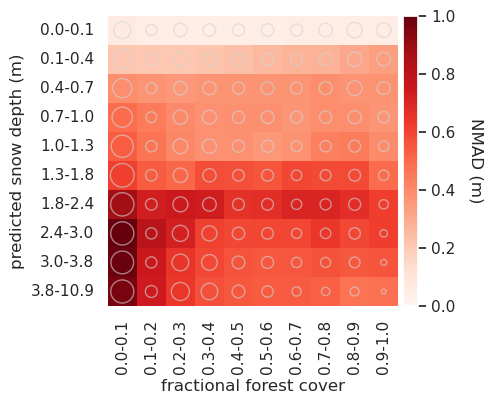

In [107]:
# Create the plot
f, ax = plt.subplots(figsize=(4, 4))
heatmap = sns.heatmap(heatmap_data, vmin=0, vmax=1, cmap='Reds', ax=ax, cbar=False)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.fcf_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_xlabel('fractional forest cover')

# Customize y-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.predicted_sd_corrected_bins.cat.categories]
ax.set_yticklabels(new_labels)
ax.set_ylabel('predicted snow depth (m)')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar with adjusted size
cbar = plt.colorbar(heatmap.get_children()[0], cax=cax)
cbar.set_label('NMAD (m)', rotation=270, labelpad=20)

# Plot scatter points on top of heatmap
for i in range(len(grouped_df)):
    x = grouped_df['fcf'].cat.codes[i]
    y = grouped_df['predicted_sd_corrected'].cat.codes[i]
    size = grouped_df['count'][i] / 1200  # Scale the size for better visualization
    ax.scatter(x + 0.5, y + 0.5, s=size, c='none', edgecolor='lightgray', alpha=0.6)

ax.set_aspect('equal')

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_pred_sd_fcf_heatmap.png', dpi=400, bbox_inches='tight')

In [116]:
grouped_df = df.groupby(['predicted_sd_corrected_bins', 'month']).agg({'error_corrected': [nmad, 'count']}).reset_index()
grouped_df.columns = ['predicted_sd_corrected', 'month', 'nmad', 'count']
grouped_df = grouped_df[grouped_df['count'] >= 1000]
heatmap_data = grouped_df.pivot(index='predicted_sd_corrected', columns='month', values='nmad')

/tmp/ipykernel_8993/122159114.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['predicted_sd_corrected_bins', 'month']).agg({'error_corrected': [nmad, 'count']}).reset_index()


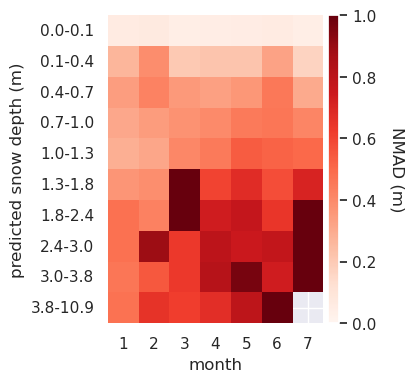

In [117]:
# Create the plot
f, ax = plt.subplots(figsize=(4, 4))
heatmap = sns.heatmap(heatmap_data, vmin=0, vmax=1, cmap='Reds', ax=ax, cbar=False)

ax.set_xlabel('month')

# Customize y-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.predicted_sd_corrected_bins.cat.categories]
ax.set_yticklabels(new_labels)
ax.set_ylabel('predicted snow depth (m)')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar with adjusted size
cbar = plt.colorbar(heatmap.get_children()[0], cax=cax)
cbar.set_label('NMAD (m)', rotation=270, labelpad=20)

# # Plot scatter points on top of heatmap
# for i in range(len(grouped_df)):
#     x = grouped_df['month'].cat.codes[i]
#     y = grouped_df['predicted_sd_corrected'].cat.codes[i]
#     size = grouped_df['count'][i] / 1200  # Scale the size for better visualization
#     ax.scatter(x + 0.5, y + 0.5, s=size, c='none', edgecolor='lightgray', alpha=0.6)

ax.set_aspect('equal')

f.savefig('../../../figs/quinn_ResDepthv10_256epochs_pred_sd_month_heatmap.png', dpi=400, bbox_inches='tight')

## standardize error with predicted error

In [ ]:
## not working yet
except Exception as e:
    print("this isn't working yet!", e)

from scipy.interpolate import griddata

# Function to calculate bin centers
def calculate_bin_centers(bins):
    return [(interval.left + interval.right) / 2 for interval in bins]

# Calculate bin centers
df['predicted_sd_corrected_center'] = df['predicted_sd_corrected_bins'].apply(lambda x: (x.left + x.right) / 2)
df['elevation_center'] = df['elevation_bins'].apply(lambda x: (x.left + x.right) / 2)
df['slope_center'] = df['slope_bins'].apply(lambda x: (x.left + x.right) / 2)
df['fcf_center'] = df['fcf_bins'].apply(lambda x: (x.left + x.right) / 2)

# Group by bins and calculate NMAD
def nmad(x):
    return 1.4826 * np.median(np.abs(x - np.median(x)))

grouped = df.groupby(['predicted_sd_corrected_bins', 'elevation_bins', 'slope_bins', 'fcf_bins']).agg({'error': [nmad, 'count']})
grouped.columns = ['nmad', 'count']

# Convert MultiIndex to numerical bin centers for interpolation
centers = grouped.index.to_frame()
centers['predicted_sd_corrected_center'] = calculate_bin_centers(centers['predicted_sd_corrected_bins'])
centers['elevation_center'] = calculate_bin_centers(centers['elevation_bins'])
centers['slope_center'] = calculate_bin_centers(centers['slope_bins'])
centers['fcf_center'] = calculate_bin_centers(centers['fcf_bins'])
points = centers[['predicted_sd_corrected_center', 'elevation_center', 'slope_center', 'fcf_center']].values

values = grouped['nmad'].values

# Create a grid for interpolation
grid_x, grid_y, grid_z, grid_w = np.meshgrid(
    calculate_bin_centers(df['predicted_sd_corrected_bins'].cat.categories),
    calculate_bin_centers(df['elevation_bins'].cat.categories),
    calculate_bin_centers(df['slope_bins'].cat.categories),
    calculate_bin_centers(df['fcf_bins'].cat.categories)
)

# Flatten the grid arrays and interpolate
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel(), grid_w.ravel()]).T
grid_nmad = griddata(points, values, grid_points, method='linear')

interpolated_nmad = griddata(points, values, grid_points, method='linear').reshape(len(bin_centers['predicted_sd_corrected']), len(bin_centers['elevation']), len(bin_centers['slope']), len(bin_centers['fcf']))

# Step 5: Map interpolated NMAD values to the original DataFrame
df['interpolated_nmad'] = interpolated_nmad[df['predicted_sd_corrected_bins'], df['elevation_bins'], df['slope_bins'], df['fcf_bins']]

# Divide error by the interpolated NMAD
df['standardized_error'] = df['error'] / df['interpolated_nmad']

print(df[['error', 'interpolated_nmad', 'standardized_error']])